In [50]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

import nibabel as nib

### 3D MRI and labels loading

In [47]:
mri_data_path = "Features/Features/prep_wf"
patients = os.listdir(mri_data_path)
patients = [patient for patient in patients if "sub" in patient]
mri_t1_data_paths = [os.path.join(mri_data_path, patient, patient + "_t1_brain-final.nii.gz") for patient in patients]
len(mri_t1_data_paths)

267

In [48]:
mri_t1_data = np.stack([nib.load(path).get_fdata() for path in mri_t1_data_paths])
mri_t1_data.shape

(267, 197, 233, 189)

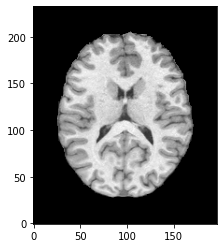

In [49]:
plt.imshow(mri_t1_data[0][:, :, 90].T, cmap='gray', origin='lower')

In [51]:
mri_labels_path = "Features/Features/preprocessed_data/label_bernaskoni"
labels = os.listdir(mri_labels_path)
len(labels)

201

In [52]:
right_indices = []
for label in labels:
    if ("sub-" + label.split('.')[0]) in patients:
        right_indices.append(patients.index("sub-" + label.split('.')[0]))
    else:
        right_indices.append(-1)
len(right_indices)

201

In [53]:
right_labels = [-1] * len(patients)
for i in range(len(right_indices)):
    if labels[i] != -1:
        right_labels[right_indices[i]] = labels[i] 

In [54]:
labels_paths = [os.path.join(mri_labels_path, label) for label in right_labels if label != -1 and "nii" in label]
label_data = np.stack([nib.load(path).get_fdata() for path in labels_paths])
label_data.shape

(198, 197, 233, 189)

In [55]:
right_labels_bool = np.array(['nii' in str(label) for label in right_labels])
mri_t1_data = mri_t1_data[right_labels_bool, :, :, :]
mri_t1_data.shape

(198, 197, 233, 189)

In [56]:
np.sort(np.where(label_data[0] > 0)[2])

array([40, 40, 40, ..., 78, 78, 78])

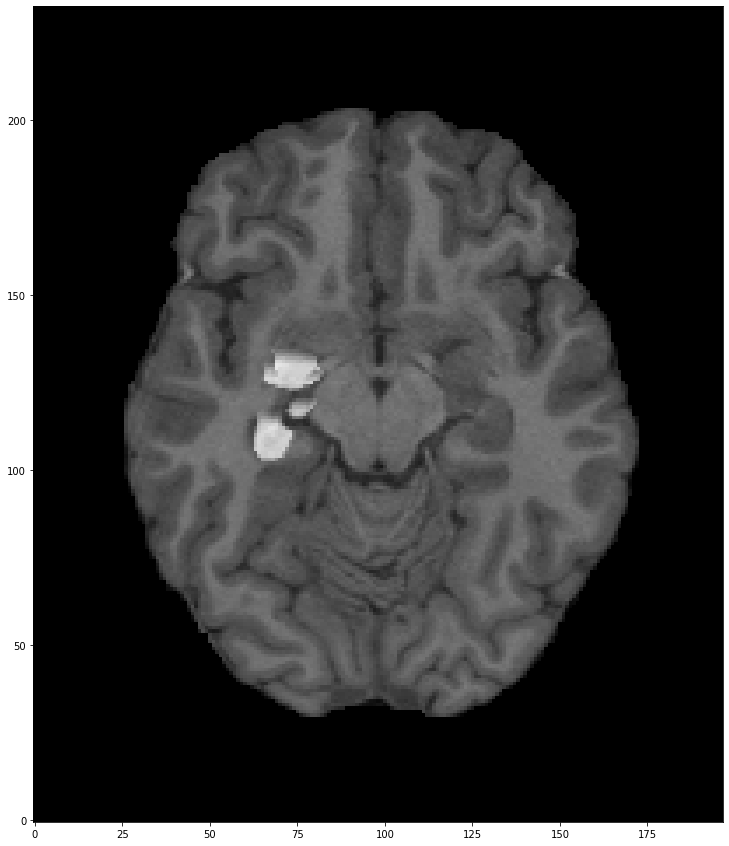

In [57]:
plt.figure(figsize=(15, 15))
plt.imshow(mri_t1_data[0][:, :, 60].T + label_data[0][:, :, 60].T, cmap='gray', origin='lower')
plt.imshow(label_data[0][:, :, 60].T, cmap='gray', origin='lower', alpha=0.5)
plt.savefig('mri-slice-with-mask.jpeg')

In [39]:
plt.imsave('mri-slice.jpeg', mri_t1_data[0][:, :, 60], cmap='gray' )

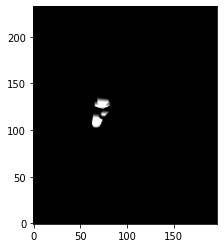

In [11]:
plt.imshow(label_data[0][:, :, 60].T, cmap='gray', origin='lower')

MRI data is in the mr1_t1_data array, labels is in the label_data array

### Pretrained runwayml/stable-diffusion-inpainting

In [12]:
!pip install torch==2.0.0


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [13]:
!pip install transformers
!pip install diffusers
!pip install accelerate


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [14]:
import PIL
import requests
import torch
from io import BytesIO
import torchvision

from diffusers import StableDiffusionInpaintPipeline

In [203]:
ax_slice_idx = 3
np.unique(np.sort(np.where(label_data[ax_slice_idx] > 0))[2])

array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55])

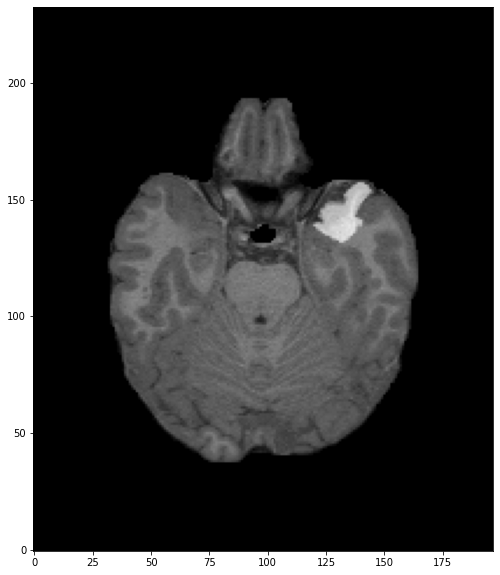

In [192]:
image = mri_t1_data[ax_slice_idx][:, :, 45].T
mask = label_data[ax_slice_idx][:, :, 45].T

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray', origin='lower')
plt.imshow(mask, cmap='gray', origin='lower', alpha=0.4)

In [21]:
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
)
pipeline = pipeline.to("cuda")

vae/diffusion_pytorch_model.safetensors not found


/root/miniconda3/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [68]:
def prepare_image_mask(image, mask):
    image = torch.tensor(image)
    mask = torch.tensor(mask)
    resizer = torchvision.transforms.Resize((232, 200))
    image = resizer(image.reshape(1, 233, 197))
    mask = resizer(mask.reshape(1, 233, 197))
    image=image.repeat(3, 1, 1)
    
    mask[mask > 0] = 1
    image = (image - image.min()) / (image.max() - image.min())
    
    return image, mask

In [69]:
image_prep, mask_prep = prepare_image_mask(image, mask) # (C, H, W)

In [43]:
generated_image = pipeline(prompt='pathology', image=image_prep, mask_image=mask_prep, height=232, width=200).images[0]

In [85]:
generated_np = np.array(generated_image) # (H, W, C)

### Creating 2D dataset

In [10]:
axial_ids = []
for label in label_data:
    axial_ids.append(np.unique(np.sort(np.where(label > 0)[2])))

In [11]:
label_data.shape

(197, 197, 233, 189)

In [12]:
axial_ids[1].shape

(8,)

In [13]:
label_data[0, :, :, axial_ids[0]].shape

(39, 197, 233)

In [24]:
best_slices = []
best_slices_labels = []
num_slices_per_mri = 5
for idx, ax_ids in enumerate(axial_ids):
    best_slice_idx = ax_ids[label_data[idx, :, :, ax_ids].sum(axis=(1, 2)).argsort()[-num_slices_per_mri:]]
    best_slices.append(mri_t1_data[idx][:, :, best_slice_idx])
    best_slices_labels.append(label_data[idx][:, :, best_slice_idx])

best_slices = np.stack(best_slices, axis=0).transpose((0, 3, 1, 2))
best_slices_labels = np.stack(best_slices_labels, axis=0).transpose((0, 3, 1, 2))
best_slices.shape, best_slices_labels.shape

((197, 5, 197, 233), (197, 5, 197, 233))

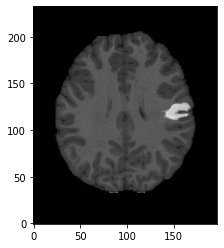

In [25]:
plt.imshow(best_slices[10][0].T, cmap='gray', origin='lower')
plt.imshow(best_slices_labels[10][0].T, cmap='gray', origin='lower', alpha=0.5)

In [26]:
torch.save(best_slices, "best_slices_ext.pt")

In [27]:
torch.save(best_slices_labels, "best_slices_labels_ext.pt")